In [1]:
%pip install Sastrawi

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import re
import string
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from string import punctuation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pickle
from joblib import dump
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\Ahmad
[nltk_data]     Dani\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
data = pd.read_csv('data/dataset-september.csv', delimiter=';')
df_stopwords = pd.read_csv('data/stopwords-id.csv', header=None, names=['stopword'])
df_slang = pd.read_csv('data/kamus-singkatan.csv', delimiter=';', names=['singkatan', 'kata'])
df_lexicon = pd.read_csv('data/lexicon-inset.csv')
lexicon_dict = dict(zip(df_lexicon['word'], df_lexicon['weight']))
df_corpus = pd.read_csv('data/corpus.csv')
corpus_words = df_corpus['kata'].tolist()

stemmer = StemmerFactory().create_stemmer()

In [5]:
def cleaning(full_text): 
    full_text = full_text.replace('-ness', ' ')
    full_text = full_text.replace('-jualness', ' ')
    full_text = re.sub(r'@\S+', ' ', full_text)
    full_text = re.sub(r'^RT[\s]+', ' ', full_text)
    full_text = re.sub(r'[^a-zA-Z]', ' ', full_text)
    full_text = re.sub(r'/n', ' ', full_text)
    full_text = re.sub(r'http\S+', ' ', full_text)
    full_text = re.sub(r'https\S+', ' ', full_text)
    full_text = re.sub(r'www\S+', ' ', full_text)
    full_text = re.sub(r'\d+', ' ', full_text)
    full_text = re.sub(r'(?<!\bunnes)(\w)(\1+)(?=\s|[\.,!])', ' ', full_text)
    full_text = full_text.strip(' ')
    full_text = full_text.lower()
    
    tokens = nltk.word_tokenize(full_text)
    
    punc = list(punctuation)
    words = [w for w in tokens if w not in punc]
    stop_words = set(stopwords.words('indonesian'))
    words = [w.lower() for w in words if not w.lower() in stop_words]

    # lemmatization
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    stemming_tokens = [stemmer.stem(token) for token in words]

    text = ' '.join(stemming_tokens)
    
    return text

In [6]:
def replace_word(text):
    elongated_words = re.findall(r'\b\w*(?:(\w)\1{2,})\w*\b', text)
    for word in elongated_words:
        replacement = word[0]
        text = re.sub(r'\b' + re.escape(word) + r'\b', replacement, text)
    return text

In [7]:
def translate_slang(text_list):
    translated_list = []
    for text in text_list:
        words = text.split()
        translated_words = []
        for word in words:
            if word in df_slang['singkatan'].tolist():
                translated_words.append(df_slang[df_slang['singkatan'] == word]['kata'].values[0])
            else:
                translated_words.append(word)
        translated_list.append(' '.join(translated_words))
    return translated_list

In [8]:
def remove_stopwords(tokens):
    if isinstance(tokens, list):
        filtered_words = [word for word in tokens if word.lower() not in df_stopwords['stopword'].values]
        return filtered_words
    else:
        return tokens
    
def stemming(tokens):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    stemming_tokens = [stemmer.stem(token) for token in tokens]
    stemming_words = ' '.join(stemming_tokens)
    return stemming_words

In [9]:
def labelling(text):
  tokens = text.split()
  score = 0
  
  for token in tokens:
    if token in lexicon_dict:
      score += lexicon_dict[token]

  polarity = ''
  if score > 0:
    polarity = 'Positif'
    scores = 2
  elif score < 0:
    polarity = 'Negatif'
    scores = 0
  else:
    polarity = 'Netral'
    scores = 1
  
  return {'polarity': polarity, 'score': scores}

In [10]:
def tokenize(text):
    text = word_tokenize(text)
    return text

In [11]:
# def proses(data):
#     data['clean_text'] = data['full_text'].apply(cleaning)
#     data['clean_text'] = data['clean_text'].apply(replace_word)
#     data['clean_text'] = data['clean_text'].apply(tokenize)
#     data['clean_text'] = data['clean_text'].apply(translate_slang)
#     data['clean_text'] = data['clean_text'].apply(remove_stopwords)
#     data['clean_text'] = data['clean_text'].apply(stemming)
#     data['sentimen'] = data['clean_text'].apply(labelling)
#     return data


In [12]:
data['clean_text'] = data['full_text'].apply(cleaning)
data

,created_at,id_str,full_text,quote_count,reply_count,retweet_count,favorite_count,lang,user_id_str,conversation_id_str,username,tweet_url,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,clean_text
0,Fri Sep 01 23:59:39 +0000 2023,"1,69776E+18","-ness buat penikmat seblak nih, menurut kalian...",0.0,8.0,0,1,in,"1,18728E+18","1,69776E+18",unnesmenfess,https://twitter.com/unnesmenfess/status/169776...,NaN,NaN,NaN,NaN,NaN,nikmat seblak nih mending seblak gendhis boom ...
1,Fri Sep 01 23:53:31 +0000 2023,"1,69776E+18","-ness lagi banyak berita pencurian laptop, pli...",0.0,2.0,0,6,in,"1,18728E+18","1,69776E+18",unnesmenfess,https://twitter.com/unnesmenfess/status/169775...,NaN,NaN,NaN,NaN,NaN,berita curi laptop pli tips gak si nyimpen bar...
2,Fri Sep 01 23:45:31 +0000 2023,"1,69776E+18",#NAME?,0.0,3.0,0,0,in,"1,18728E+18","1,69776E+18",unnesmenfess,https://twitter.com/unnesmenfess/status/169775...,NaN,NaN,NaN,NaN,NaN,name
3,Fri Sep 01 23:39:25 +0000 2023,"1,69776E+18",@unnesmenfess Aih mauu tapi ke unnes Selasaaa😢,0.0,0.0,0,0,in,"1,1333E+18","1,69765E+18",fanfaaannn,https://twitter.com/fanfaaannn/status/16977560...,NaN,NaN,NaN,NaN,NaN,aih ma unnes las
4,Fri Sep 01 23:26:07 +0000 2023,"1,69775E+18",#NAME?,0.0,3.0,0,0,in,"1,18728E+18","1,69775E+18",unnesmenfess,https://twitter.com/unnesmenfess/status/169775...,NaN,NaN,NaN,NaN,NaN,name
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10268,Wed Sep 20 01:11:59 +0000 2023,"1,7043E+18",@RSquare_1 @undipmenfess emng satpam unnes ramah?,0.0,2.0,0,0,in,2835804066,"1,70413E+18",putrarukma,https://twitter.com/putrarukma/status/17043023...,NaN,NaN,NaN,NaN,NaN,emng satpam unnes ramah
10269,Wed Sep 20 00:37:09 +0000 2023,"1,70429E+18","@SmgMenfess2 ati ati nder, lagek pertama meet ...",0.0,0.0,0,0,in,"1,22566E+18","1,70418E+18",dinisahh17_,https://twitter.com/dinisahh17_/status/1704293...,NaN,NaN,NaN,NaN,NaN,ati ati nder lagek meet i lho
10270,Wed Sep 20 00:35:25 +0000 2023,"1,70429E+18","@m_milladina bennn dee ganteni pekerjaanku, ak...",0.0,0.0,0,0,in,"1,22566E+18","1,70428E+18",dinisahh17_,https://twitter.com/dinisahh17_/status/1704293...,NaN,NaN,NaN,NaN,NaN,be d ganteni kerja turu
10271,Wed Sep 20 00:34:44 +0000 2023,"1,70429E+18","@m_milladina emoh oggg, wayahe nde yang",0.0,1.0,0,0,in,"1,22566E+18","1,70428E+18",dinisahh17_,https://twitter.com/dinisahh17_/status/1704292...,NaN,NaN,NaN,NaN,NaN,emoh o wayahe nde


In [13]:
data['clean_text'] = data['clean_text'].apply(replace_word)
data

,created_at,id_str,full_text,quote_count,reply_count,retweet_count,favorite_count,lang,user_id_str,conversation_id_str,username,tweet_url,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,clean_text
0,Fri Sep 01 23:59:39 +0000 2023,"1,69776E+18","-ness buat penikmat seblak nih, menurut kalian...",0.0,8.0,0,1,in,"1,18728E+18","1,69776E+18",unnesmenfess,https://twitter.com/unnesmenfess/status/169776...,NaN,NaN,NaN,NaN,NaN,nikmat seblak nih mending seblak gendhis boom ...
1,Fri Sep 01 23:53:31 +0000 2023,"1,69776E+18","-ness lagi banyak berita pencurian laptop, pli...",0.0,2.0,0,6,in,"1,18728E+18","1,69776E+18",unnesmenfess,https://twitter.com/unnesmenfess/status/169775...,NaN,NaN,NaN,NaN,NaN,berita curi laptop pli tips gak si nyimpen bar...
2,Fri Sep 01 23:45:31 +0000 2023,"1,69776E+18",#NAME?,0.0,3.0,0,0,in,"1,18728E+18","1,69776E+18",unnesmenfess,https://twitter.com/unnesmenfess/status/169775...,NaN,NaN,NaN,NaN,NaN,name
3,Fri Sep 01 23:39:25 +0000 2023,"1,69776E+18",@unnesmenfess Aih mauu tapi ke unnes Selasaaa😢,0.0,0.0,0,0,in,"1,1333E+18","1,69765E+18",fanfaaannn,https://twitter.com/fanfaaannn/status/16977560...,NaN,NaN,NaN,NaN,NaN,aih ma unnes las
4,Fri Sep 01 23:26:07 +0000 2023,"1,69775E+18",#NAME?,0.0,3.0,0,0,in,"1,18728E+18","1,69775E+18",unnesmenfess,https://twitter.com/unnesmenfess/status/169775...,NaN,NaN,NaN,NaN,NaN,name
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10268,Wed Sep 20 01:11:59 +0000 2023,"1,7043E+18",@RSquare_1 @undipmenfess emng satpam unnes ramah?,0.0,2.0,0,0,in,2835804066,"1,70413E+18",putrarukma,https://twitter.com/putrarukma/status/17043023...,NaN,NaN,NaN,NaN,NaN,emng satpam unnes ramah
10269,Wed Sep 20 00:37:09 +0000 2023,"1,70429E+18","@SmgMenfess2 ati ati nder, lagek pertama meet ...",0.0,0.0,0,0,in,"1,22566E+18","1,70418E+18",dinisahh17_,https://twitter.com/dinisahh17_/status/1704293...,NaN,NaN,NaN,NaN,NaN,ati ati nder lagek meet i lho
10270,Wed Sep 20 00:35:25 +0000 2023,"1,70429E+18","@m_milladina bennn dee ganteni pekerjaanku, ak...",0.0,0.0,0,0,in,"1,22566E+18","1,70428E+18",dinisahh17_,https://twitter.com/dinisahh17_/status/1704293...,NaN,NaN,NaN,NaN,NaN,be d ganteni kerja turu
10271,Wed Sep 20 00:34:44 +0000 2023,"1,70429E+18","@m_milladina emoh oggg, wayahe nde yang",0.0,1.0,0,0,in,"1,22566E+18","1,70428E+18",dinisahh17_,https://twitter.com/dinisahh17_/status/1704292...,NaN,NaN,NaN,NaN,NaN,emoh o wayahe nde


In [14]:
data['clean_text'] = data['clean_text'].apply(tokenize)
data

,created_at,id_str,full_text,quote_count,reply_count,retweet_count,favorite_count,lang,user_id_str,conversation_id_str,username,tweet_url,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,clean_text
0,Fri Sep 01 23:59:39 +0000 2023,"1,69776E+18","-ness buat penikmat seblak nih, menurut kalian...",0.0,8.0,0,1,in,"1,18728E+18","1,69776E+18",unnesmenfess,https://twitter.com/unnesmenfess/status/169776...,NaN,NaN,NaN,NaN,NaN,"[nikmat, seblak, nih, mending, seblak, gendhis..."
1,Fri Sep 01 23:53:31 +0000 2023,"1,69776E+18","-ness lagi banyak berita pencurian laptop, pli...",0.0,2.0,0,6,in,"1,18728E+18","1,69776E+18",unnesmenfess,https://twitter.com/unnesmenfess/status/169775...,NaN,NaN,NaN,NaN,NaN,"[berita, curi, laptop, pli, tips, gak, si, nyi..."
2,Fri Sep 01 23:45:31 +0000 2023,"1,69776E+18",#NAME?,0.0,3.0,0,0,in,"1,18728E+18","1,69776E+18",unnesmenfess,https://twitter.com/unnesmenfess/status/169775...,NaN,NaN,NaN,NaN,NaN,[name]
3,Fri Sep 01 23:39:25 +0000 2023,"1,69776E+18",@unnesmenfess Aih mauu tapi ke unnes Selasaaa😢,0.0,0.0,0,0,in,"1,1333E+18","1,69765E+18",fanfaaannn,https://twitter.com/fanfaaannn/status/16977560...,NaN,NaN,NaN,NaN,NaN,"[aih, ma, unnes, las]"
4,Fri Sep 01 23:26:07 +0000 2023,"1,69775E+18",#NAME?,0.0,3.0,0,0,in,"1,18728E+18","1,69775E+18",unnesmenfess,https://twitter.com/unnesmenfess/status/169775...,NaN,NaN,NaN,NaN,NaN,[name]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10268,Wed Sep 20 01:11:59 +0000 2023,"1,7043E+18",@RSquare_1 @undipmenfess emng satpam unnes ramah?,0.0,2.0,0,0,in,2835804066,"1,70413E+18",putrarukma,https://twitter.com/putrarukma/status/17043023...,NaN,NaN,NaN,NaN,NaN,"[emng, satpam, unnes, ramah]"
10269,Wed Sep 20 00:37:09 +0000 2023,"1,70429E+18","@SmgMenfess2 ati ati nder, lagek pertama meet ...",0.0,0.0,0,0,in,"1,22566E+18","1,70418E+18",dinisahh17_,https://twitter.com/dinisahh17_/status/1704293...,NaN,NaN,NaN,NaN,NaN,"[ati, ati, nder, lagek, meet, i, lho]"
10270,Wed Sep 20 00:35:25 +0000 2023,"1,70429E+18","@m_milladina bennn dee ganteni pekerjaanku, ak...",0.0,0.0,0,0,in,"1,22566E+18","1,70428E+18",dinisahh17_,https://twitter.com/dinisahh17_/status/1704293...,NaN,NaN,NaN,NaN,NaN,"[be, d, ganteni, kerja, turu]"
10271,Wed Sep 20 00:34:44 +0000 2023,"1,70429E+18","@m_milladina emoh oggg, wayahe nde yang",0.0,1.0,0,0,in,"1,22566E+18","1,70428E+18",dinisahh17_,https://twitter.com/dinisahh17_/status/1704292...,NaN,NaN,NaN,NaN,NaN,"[emoh, o, wayahe, nde]"


In [15]:
data['clean_text'] = data['clean_text'].apply(translate_slang)
data

,created_at,id_str,full_text,quote_count,reply_count,retweet_count,favorite_count,lang,user_id_str,conversation_id_str,username,tweet_url,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,clean_text
0,Fri Sep 01 23:59:39 +0000 2023,"1,69776E+18","-ness buat penikmat seblak nih, menurut kalian...",0.0,8.0,0,1,in,"1,18728E+18","1,69776E+18",unnesmenfess,https://twitter.com/unnesmenfess/status/169776...,NaN,NaN,NaN,NaN,NaN,"[nikmat, seblak, nih, mending, seblak, gendhis..."
1,Fri Sep 01 23:53:31 +0000 2023,"1,69776E+18","-ness lagi banyak berita pencurian laptop, pli...",0.0,2.0,0,6,in,"1,18728E+18","1,69776E+18",unnesmenfess,https://twitter.com/unnesmenfess/status/169775...,NaN,NaN,NaN,NaN,NaN,"[berita, curi, laptop, pli, tips, tidak , sih,..."
2,Fri Sep 01 23:45:31 +0000 2023,"1,69776E+18",#NAME?,0.0,3.0,0,0,in,"1,18728E+18","1,69776E+18",unnesmenfess,https://twitter.com/unnesmenfess/status/169775...,NaN,NaN,NaN,NaN,NaN,[name]
3,Fri Sep 01 23:39:25 +0000 2023,"1,69776E+18",@unnesmenfess Aih mauu tapi ke unnes Selasaaa😢,0.0,0.0,0,0,in,"1,1333E+18","1,69765E+18",fanfaaannn,https://twitter.com/fanfaaannn/status/16977560...,NaN,NaN,NaN,NaN,NaN,"[aih, ma, unnes, las]"
4,Fri Sep 01 23:26:07 +0000 2023,"1,69775E+18",#NAME?,0.0,3.0,0,0,in,"1,18728E+18","1,69775E+18",unnesmenfess,https://twitter.com/unnesmenfess/status/169775...,NaN,NaN,NaN,NaN,NaN,[name]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10268,Wed Sep 20 01:11:59 +0000 2023,"1,7043E+18",@RSquare_1 @undipmenfess emng satpam unnes ramah?,0.0,2.0,0,0,in,2835804066,"1,70413E+18",putrarukma,https://twitter.com/putrarukma/status/17043023...,NaN,NaN,NaN,NaN,NaN,"[memang , satpam, unnes, ramah]"
10269,Wed Sep 20 00:37:09 +0000 2023,"1,70429E+18","@SmgMenfess2 ati ati nder, lagek pertama meet ...",0.0,0.0,0,0,in,"1,22566E+18","1,70418E+18",dinisahh17_,https://twitter.com/dinisahh17_/status/1704293...,NaN,NaN,NaN,NaN,NaN,"[ati, ati, nder, lagi, meet, i, lho]"
10270,Wed Sep 20 00:35:25 +0000 2023,"1,70429E+18","@m_milladina bennn dee ganteni pekerjaanku, ak...",0.0,0.0,0,0,in,"1,22566E+18","1,70428E+18",dinisahh17_,https://twitter.com/dinisahh17_/status/1704293...,NaN,NaN,NaN,NaN,NaN,"[be, d, ganteni, kerja, tidur]"
10271,Wed Sep 20 00:34:44 +0000 2023,"1,70429E+18","@m_milladina emoh oggg, wayahe nde yang",0.0,1.0,0,0,in,"1,22566E+18","1,70428E+18",dinisahh17_,https://twitter.com/dinisahh17_/status/1704292...,NaN,NaN,NaN,NaN,NaN,"[tidak mau, o, momen, nde]"


In [16]:
data['clean_text'] = data['clean_text'].apply(remove_stopwords)
data

,created_at,id_str,full_text,quote_count,reply_count,retweet_count,favorite_count,lang,user_id_str,conversation_id_str,username,tweet_url,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,clean_text
0,Fri Sep 01 23:59:39 +0000 2023,"1,69776E+18","-ness buat penikmat seblak nih, menurut kalian...",0.0,8.0,0,1,in,"1,18728E+18","1,69776E+18",unnesmenfess,https://twitter.com/unnesmenfess/status/169776...,NaN,NaN,NaN,NaN,NaN,"[nikmat, seblak, mending, seblak, gendhis, boo..."
1,Fri Sep 01 23:53:31 +0000 2023,"1,69776E+18","-ness lagi banyak berita pencurian laptop, pli...",0.0,2.0,0,6,in,"1,18728E+18","1,69776E+18",unnesmenfess,https://twitter.com/unnesmenfess/status/169775...,NaN,NaN,NaN,NaN,NaN,"[berita, curi, laptop, pli, tips, tidak , nyim..."
2,Fri Sep 01 23:45:31 +0000 2023,"1,69776E+18",#NAME?,0.0,3.0,0,0,in,"1,18728E+18","1,69776E+18",unnesmenfess,https://twitter.com/unnesmenfess/status/169775...,NaN,NaN,NaN,NaN,NaN,[name]
3,Fri Sep 01 23:39:25 +0000 2023,"1,69776E+18",@unnesmenfess Aih mauu tapi ke unnes Selasaaa😢,0.0,0.0,0,0,in,"1,1333E+18","1,69765E+18",fanfaaannn,https://twitter.com/fanfaaannn/status/16977560...,NaN,NaN,NaN,NaN,NaN,"[aih, ma, unnes, las]"
4,Fri Sep 01 23:26:07 +0000 2023,"1,69775E+18",#NAME?,0.0,3.0,0,0,in,"1,18728E+18","1,69775E+18",unnesmenfess,https://twitter.com/unnesmenfess/status/169775...,NaN,NaN,NaN,NaN,NaN,[name]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10268,Wed Sep 20 01:11:59 +0000 2023,"1,7043E+18",@RSquare_1 @undipmenfess emng satpam unnes ramah?,0.0,2.0,0,0,in,2835804066,"1,70413E+18",putrarukma,https://twitter.com/putrarukma/status/17043023...,NaN,NaN,NaN,NaN,NaN,"[memang , satpam, unnes, ramah]"
10269,Wed Sep 20 00:37:09 +0000 2023,"1,70429E+18","@SmgMenfess2 ati ati nder, lagek pertama meet ...",0.0,0.0,0,0,in,"1,22566E+18","1,70418E+18",dinisahh17_,https://twitter.com/dinisahh17_/status/1704293...,NaN,NaN,NaN,NaN,NaN,"[ati, ati, nder, meet, i, lho]"
10270,Wed Sep 20 00:35:25 +0000 2023,"1,70429E+18","@m_milladina bennn dee ganteni pekerjaanku, ak...",0.0,0.0,0,0,in,"1,22566E+18","1,70428E+18",dinisahh17_,https://twitter.com/dinisahh17_/status/1704293...,NaN,NaN,NaN,NaN,NaN,"[be, d, ganteni, kerja, tidur]"
10271,Wed Sep 20 00:34:44 +0000 2023,"1,70429E+18","@m_milladina emoh oggg, wayahe nde yang",0.0,1.0,0,0,in,"1,22566E+18","1,70428E+18",dinisahh17_,https://twitter.com/dinisahh17_/status/1704292...,NaN,NaN,NaN,NaN,NaN,"[tidak mau, o, momen, nde]"


In [17]:
data['clean_text'] = data['clean_text'].apply(stemming)
data

,created_at,id_str,full_text,quote_count,reply_count,retweet_count,favorite_count,lang,user_id_str,conversation_id_str,username,tweet_url,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,clean_text
0,Fri Sep 01 23:59:39 +0000 2023,"1,69776E+18","-ness buat penikmat seblak nih, menurut kalian...",0.0,8.0,0,1,in,"1,18728E+18","1,69776E+18",unnesmenfess,https://twitter.com/unnesmenfess/status/169776...,NaN,NaN,NaN,NaN,NaN,nikmat seblak mending seblak gendhis boom bageur
1,Fri Sep 01 23:53:31 +0000 2023,"1,69776E+18","-ness lagi banyak berita pencurian laptop, pli...",0.0,2.0,0,6,in,"1,18728E+18","1,69776E+18",unnesmenfess,https://twitter.com/unnesmenfess/status/169775...,NaN,NaN,NaN,NaN,NaN,berita curi laptop pli tips tidak nyimpen bara...
2,Fri Sep 01 23:45:31 +0000 2023,"1,69776E+18",#NAME?,0.0,3.0,0,0,in,"1,18728E+18","1,69776E+18",unnesmenfess,https://twitter.com/unnesmenfess/status/169775...,NaN,NaN,NaN,NaN,NaN,name
3,Fri Sep 01 23:39:25 +0000 2023,"1,69776E+18",@unnesmenfess Aih mauu tapi ke unnes Selasaaa😢,0.0,0.0,0,0,in,"1,1333E+18","1,69765E+18",fanfaaannn,https://twitter.com/fanfaaannn/status/16977560...,NaN,NaN,NaN,NaN,NaN,aih ma unnes las
4,Fri Sep 01 23:26:07 +0000 2023,"1,69775E+18",#NAME?,0.0,3.0,0,0,in,"1,18728E+18","1,69775E+18",unnesmenfess,https://twitter.com/unnesmenfess/status/169775...,NaN,NaN,NaN,NaN,NaN,name
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10268,Wed Sep 20 01:11:59 +0000 2023,"1,7043E+18",@RSquare_1 @undipmenfess emng satpam unnes ramah?,0.0,2.0,0,0,in,2835804066,"1,70413E+18",putrarukma,https://twitter.com/putrarukma/status/17043023...,NaN,NaN,NaN,NaN,NaN,memang satpam unnes ramah
10269,Wed Sep 20 00:37:09 +0000 2023,"1,70429E+18","@SmgMenfess2 ati ati nder, lagek pertama meet ...",0.0,0.0,0,0,in,"1,22566E+18","1,70418E+18",dinisahh17_,https://twitter.com/dinisahh17_/status/1704293...,NaN,NaN,NaN,NaN,NaN,ati ati nder meet i lho
10270,Wed Sep 20 00:35:25 +0000 2023,"1,70429E+18","@m_milladina bennn dee ganteni pekerjaanku, ak...",0.0,0.0,0,0,in,"1,22566E+18","1,70428E+18",dinisahh17_,https://twitter.com/dinisahh17_/status/1704293...,NaN,NaN,NaN,NaN,NaN,be d ganteni kerja tidur
10271,Wed Sep 20 00:34:44 +0000 2023,"1,70429E+18","@m_milladina emoh oggg, wayahe nde yang",0.0,1.0,0,0,in,"1,22566E+18","1,70428E+18",dinisahh17_,https://twitter.com/dinisahh17_/status/1704292...,NaN,NaN,NaN,NaN,NaN,tidak mau o momen nde


In [ ]:
# data = pd.read_excel(r'D:\10.media_social_analysis-main\After_Processed_Dataset_PASAL (2).xlsx')
# data

In [18]:
data['temp'] = data['full_text'].apply(labelling)

data['sentimen'] = data['temp'].apply(lambda x: x['polarity'])
data['sentimen_encoded'] = data['temp'].apply(lambda x: x['score'])

data.drop('temp', axis=1, inplace=True)

In [ ]:
data = pd.read_excel(r'C:\Users\Ahmad Dani\codingz\SENTIS\app\hasil_sentimen.xlsx')
data

In [19]:
data.dropna(subset=['clean_text', 'sentimen'], inplace=True)

df = pd.DataFrame(data)

df.to_excel('hasil_senti.xlsx')

In [20]:
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingClassifier

# Memisahkan fitur (X) dan label (y) dari dataset
X = data['clean_text']
y = data['sentimen']

# Penggunaan TF-IDF untuk vektorisasi teks
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X)
X_test_tfidf = vectorizer.transform(X)  # Transformasi data uji

In [21]:
from imblearn.over_sampling import SMOTE
# Ganti Random Over Sampling dengan SMOTE
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train_tfidf, y)

# Buat DataFrame baru
os = pd.DataFrame(list(zip([x[0] for x in X_resampled], y_resampled)), columns=['full_text', 'Label'])

# Tampilkan distribusi kelas setelah penerapan SMOTE
os['Label'].value_counts()

Label
Positif    4872
Negatif    4872
Netral     4872
Name: count, dtype: int64

In [22]:
# Pembagian data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, stratify=y_resampled, test_size=0.1, random_state=42)

In [23]:
# # Inisialisasi dan pelatihan model SVM dengan kernel radial basis function (RBF)
# svm_model = SVC(kernel='rbf', C=100.0, gamma=0.03)
# svm_model.fit(X_train_tfidf, y_train)
estimators = [
    ('lr', LogisticRegression()),        # Estimator 1: Logistic Regression
    ('rf', RandomForestClassifier()),    # Estimator 2: Random Forest Classifier
    ('dt', DecisionTreeClassifier()),    # Estimator 3: Decision Tree Classifier
    ('svm', SVC(kernel='rbf', C=1.0, gamma=0.01))    # Estimator 5: SVM Classifier
]

# Definisikan StackingClassifier dengan meta-estimator LogisticRegression
svm_model = StackingClassifier(
    estimators=estimators,               # Daftar estimator yang akan digunakan
    final_estimator=RandomForestClassifier()# Estimator meta untuk menggabungkan hasil estimator lainnya
)

svm_model.fit(X_train, y_train)

# Evaluasi akurasi model pada data uji
y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Evaluasi model dengan classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Simpan model dan objek vectorizer untuk penggunaan selanjutnya
dump(vectorizer, 'models/vectorizer1.pkl')
dump(svm_model, 'models/ensemble_model4.pkl')


Accuracy: 0.8850889192886456
Classification Report:
              precision    recall  f1-score   support

     Negatif       0.90      0.89      0.90       487
      Netral       0.94      0.86      0.90       487
     Positif       0.83      0.91      0.86       488

    accuracy                           0.89      1462
   macro avg       0.89      0.89      0.89      1462
weighted avg       0.89      0.89      0.89      1462



['models/ensemble_model4.pkl']

Confusion Matrix:
[[434  14  39]
 [ 16 418  53]
 [ 32  14 442]]


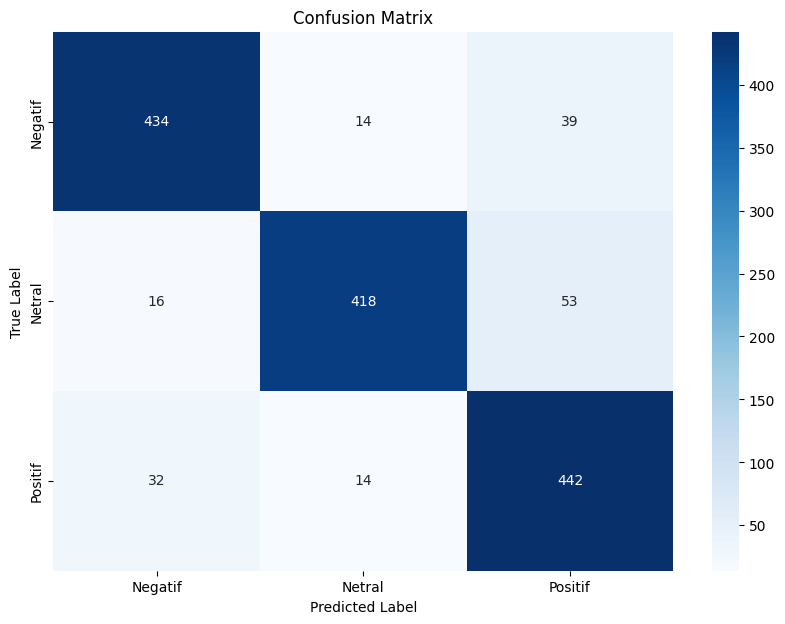

In [24]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Membuat confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix dengan label 'Negatif', 'Netral', 'Positif'
labels = ['Negatif', 'Netral', 'Positif']
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
%pip install flask